**Deep Neural Network**




In [6]:
# Connecting the Python Code with the google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
pip install shap

In [8]:
# Import necessary libraries
import sys
import os
import platform
import random
from math import sqrt, floor, ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from multiprocessing import Process
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import pickle

In [9]:
# Importing Data from google drive
dat = pd.read_csv("/content/drive/MyDrive/Emory/MAF Lecture/SixSignals_20230125.csv.zip")      # Importing Data
#dat = pd.read_csv("/content/drive/MyDrive/Emory/MAF Lecture/signals_20230125.csv")

In [10]:
dat

,yyyymm,marketcap_pct_rank,new_issue_pct_rank,investment_pct_rank,accruals_pct_rank,b2m_pct_rank,ret_2_12_pct_rank,RET,PERMNO
0,198711,0.200000,0.000000,0.000000,0.400000,0.000000,0.000000,-0.191176,85041
1,198711,-0.200000,0.200000,-0.400000,-0.200000,0.200000,-0.200000,-0.093750,52143
2,198711,-0.400000,-0.400000,-0.200000,-0.400000,-0.200000,-0.400000,-0.071429,67379
3,198711,0.400000,0.400000,0.200000,0.200000,-0.400000,0.200000,-0.068493,24539
4,198711,0.000000,-0.200000,0.400000,0.000000,0.400000,0.400000,-0.114504,29532
...,...,...,...,...,...,...,...,...,...
1534081,202203,-0.408407,0.346755,0.430531,0.444690,0.142625,-0.385693,0.128668,19139
1534082,202203,-0.139086,0.236431,0.489233,0.407817,0.153245,-0.474779,0.095125,19137
1534083,202203,0.347050,0.469764,0.299853,0.370354,-0.069764,0.057375,-0.155812,10777
1534084,202203,-0.142330,0.333186,0.162979,0.478319,-0.366814,-0.416667,-0.193136,19134


In [11]:
# Data Pre-processing

# Date-time Manipulations
dat["date"] = pd.to_datetime(dat["yyyymm"], format="%Y%m")                      # Informing python that "date" is a DateTime object for subsequent datetime manipulations like adding or subtracting months
dat["yr"] = dat["date"].dt.year                                                 # Extracting year
dat["month"] = dat["date"].dt.month                                             # Extracting month
dat.sort_values(by = 'date', inplace = True)                                    # Sorting dataframe by date
dat["month_num"] = (dat['date']).rank(method = "dense")                         # Assigning a rank for each month sequentially

# Calculating Mean & Adjusted Returns
grouped = pd.DataFrame();                                                       # Initializing DataFrame
grouped["mean"] = dat.groupby('yyyymm').apply(lambda x : x["RET"].mean())       # Computing monthly mean returns
dat['mean_ret'] = dat['yyyymm'].map(grouped["mean"])                            # Assigning mean returns to "dat["mean_ret"]" column
dat['adj_ret'] = dat['RET'] - dat['mean_ret']                                   # Adjusted Returns - subtract the mean so that the target is return minus average returns for all stocks.
                                                                                # Removes return fluctuation due to market returns - reduces "noise" in the target
# Printing Output
print("***********************************************************")
print("Pre-processed Dataframe containing all signals")
print("***********************************************************")
dat

***********************************************************
Pre-processed Dataframe containing all signals
***********************************************************


,yyyymm,marketcap_pct_rank,new_issue_pct_rank,investment_pct_rank,accruals_pct_rank,b2m_pct_rank,ret_2_12_pct_rank,RET,PERMNO,date,yr,month,month_num,mean_ret,adj_ret
0,198711,0.200000,0.000000,0.000000,0.400000,0.000000,0.000000,-0.191176,85041,1987-11-01,1987,11,1.0,-0.107870,-0.083306
1,198711,-0.200000,0.200000,-0.400000,-0.200000,0.200000,-0.200000,-0.093750,52143,1987-11-01,1987,11,1.0,-0.107870,0.014120
2,198711,-0.400000,-0.400000,-0.200000,-0.400000,-0.200000,-0.400000,-0.071429,67379,1987-11-01,1987,11,1.0,-0.107870,0.036441
3,198711,0.400000,0.400000,0.200000,0.200000,-0.400000,0.200000,-0.068493,24539,1987-11-01,1987,11,1.0,-0.107870,0.039377
4,198711,0.000000,-0.200000,0.400000,0.000000,0.400000,0.400000,-0.114504,29532,1987-11-01,1987,11,1.0,-0.107870,-0.006634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531829,202203,0.453245,-0.214307,0.158555,0.156195,-0.324631,0.293363,-0.006052,84769,2022-03-01,2022,3,413.0,0.018761,-0.024813
1531830,202203,0.173009,-0.123746,-0.078761,-0.353097,0.070354,-0.149410,-0.048630,90979,2022-03-01,2022,3,413.0,0.018761,-0.067391
1531831,202203,-0.163569,-0.400147,-0.452065,-0.240560,-0.107817,0.024336,0.181667,85401,2022-03-01,2022,3,413.0,0.018761,0.162906
1531807,202203,-0.191298,-0.049410,-0.391298,0.454130,-0.242035,0.101917,-0.354743,89891,2022-03-01,2022,3,413.0,0.018761,-0.373504


In [12]:
# Minor Pre-processing to extract available factors
y_column_name = 'adj_ret'                                                                                               # Target variable is adjusted returns
row_key_column_names = ['yyyymm', 'PERMNO', 'month', 'yr', 'month_num', 'RET', 'mean_ret','date']                       # Columns that are not signals ( either identifiers or target variables )
feature_column_names = [ x for x in dat.columns.values if (x not in row_key_column_names) & (x != y_column_name) ]      # Remaining columns are the varaibles that can potentailly be used as signals
print("************************************************************************************************************")
print("list of available signals/factors for Random Forest Model Input")
print(feature_column_names)
print("************************************************************************************************************")

************************************************************************************************************
list of available signals/factors for Random Forest Model Input
['marketcap_pct_rank', 'new_issue_pct_rank', 'investment_pct_rank', 'accruals_pct_rank', 'b2m_pct_rank', 'ret_2_12_pct_rank']
************************************************************************************************************


In [13]:
# Deep Neural Network Architecture

from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import pickle
import numpy as np

def deep_neural_network_rolling(train_X, train_y, epochs=10, batch_size=32, hidden_layers=[128, 128], dropout_rate=0.3):
    # Standardizing the data
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)

    # Splitting the data into training and validation sets (last 10% for validation)
    split_idx = int(0.9 * len(train_X_scaled))
    train_X_scaled, val_X_scaled = train_X_scaled[:split_idx], train_X_scaled[split_idx:]
    train_y, val_y = train_y[:split_idx], train_y[split_idx:]

    # Building the model
    model = Sequential()
    model.add(Dense(hidden_layers[0], input_dim=train_X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear')) # Output layer

    # Compiling the model with additional metrics
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Training the model with verbose output and validation data
    history = model.fit(train_X_scaled, train_y, epochs=epochs, batch_size=batch_size,
                        validation_data=(val_X_scaled, val_y), verbose=1)

    # Saving the model and scaler
    scaler_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/scaler_6_factor_2.pkl'
    model_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/deep_neural_trained_model_6_factor_2.h5'
    model.save(model_path)
    with open(scaler_path, 'wb') as file:
        pickle.dump(scaler, file)

    return model, scaler, history




In [14]:
## Deep Neural Network Training (If the model is already saved , Don't run this code)

predicted_ret_df = pd.DataFrame()
rolling_window = 60
maximum_month = int(dat["month_num"].max()) - rolling_window + 1

train_dat = dat[(dat['month_num'] > 0) & (dat['month_num']<=60)]  # Selecting first 100 months for training
reg_factors = feature_column_names
y_column_name = 'adj_ret'
train_X = train_dat[reg_factors]  # Replace 'reg_factors' with your features
train_y = train_dat[y_column_name]
deep_neural_network_rolling(train_X, train_y)


Epoch 1/10
4446/4446 [==============================] - 16s 3ms/step - loss: 0.0473 - mean_absolute_error: 0.1192 - val_loss: 0.0283 - val_mean_absolute_error: 0.1066
Epoch 2/10
4446/4446 [==============================] - 12s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1164 - val_loss: 0.0283 - val_mean_absolute_error: 0.1061
Epoch 3/10
4446/4446 [==============================] - 12s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1162 - val_loss: 0.0283 - val_mean_absolute_error: 0.1071
Epoch 4/10
4446/4446 [==============================] - 12s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1162 - val_loss: 0.0282 - val_mean_absolute_error: 0.1065
Epoch 5/10
4446/4446 [==============================] - 12s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1162 - val_loss: 0.0284 - val_mean_absolute_error: 0.1064
Epoch 6/10
4446/4446 [==============================] - 12s 3ms/step - loss: 0.0462 - mean_absolute_error: 0.1162 - val_loss: 0.0283 - val_mean_absolute_error: 0.106

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(<keras.src.engine.sequential.Sequential at 0x7c9fba767370>,
 StandardScaler(),
 <keras.src.callbacks.History at 0x7c9fb83136d0>)

In [15]:
rolling_window = 60
maximum_month = int(dat["month_num"].max()) - rolling_window + 1
reg_factors = feature_column_names
y_column_name = 'adj_ret'
predicted_ret_df = pd.DataFrame()
for month in range(60, 160):     # INPUT THE MONTH NUMBER/ MONTH RANGE HERE

  # Input Training data & Test Data Parameters
  print("="*50)
  print(f"Model running for month {month}")

  # Loading Scaler
  scaler_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/scaler_6_factor_2.pkl'
  with open(scaler_path, 'rb') as file:
    scaler = pickle.load(file)

  # Extracting and Scaling Test Data
  test_dat = dat[ (dat['month_num'] == (month)) ]
  test_X = test_dat[reg_factors]
  test_X_scaled = scaler.transform(test_X)
  test_y = test_dat[y_column_name]

  # Loading Trained Model
  model_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/deep_neural_trained_model_6_factor_2.h5'
  model = tf.keras.models.load_model(model_path)

  # Predicting Returns
  predicted_ret = model.predict(test_X_scaled)

  ## Predicticted Returns Calculation
  test_dat = pd.DataFrame()
  test_dat = dat[(dat['month_num'] == month )].copy()
  test_dat.loc[:,"predicted_adj_ret"] = model.predict(test_X_scaled)
  test_dat.rename(columns = {"adj_ret" : "actual_adj_ret"},inplace = True)
  test_dat = test_dat[["PERMNO","yr","month","predicted_adj_ret", "actual_adj_ret", "RET"]]
  predicted_ret_df = pd.concat([predicted_ret_df, test_dat], axis =0)

print("****************************************************************************")
print("Dataframe with predicted returns")
print("****************************************************************************")
predicted_ret_df

Model running for month 60
110/110 [==============================] - 0s 1ms/step
Model running for month 61
111/111 [==============================] - 0s 1ms/step
Model running for month 62
110/110 [==============================] - 0s 1ms/step
Model running for month 63
110/110 [==============================] - 0s 1ms/step
Model running for month 64
110/110 [==============================] - 0s 1ms/step
Model running for month 65
110/110 [==============================] - 0s 1ms/step
Model running for month 66
109/109 [==============================] - 0s 1ms/step
Model running for month 67
115/115 [==============================] - 0s 1ms/step
Model running for month 68
115/115 [==============================] - 0s 1ms/step
Model running for month 69
115/115 [==============================] - 0s 1ms/step
Model running for month 70
116/116 [==============================] - 0s 1ms/step
Model running for month 71
115/115 [==============================] - 0s 1ms/step
Model running fo

,PERMNO,yr,month,predicted_adj_ret,actual_adj_ret,RET
156905,11955,1992,10,-0.007627,0.135068,0.155556
156898,77463,1992,10,-0.001369,0.022990,0.043478
156899,38543,1992,10,-0.001369,-0.091917,-0.071429
156900,56629,1992,10,-0.001369,0.170421,0.190909
156901,11541,1992,10,-0.001369,0.458964,0.479452
...,...,...,...,...,...,...
576770,82638,2001,1,-0.026537,-0.152793,0.113043
576766,80609,2001,1,0.000722,-0.108913,0.156923
576750,49031,2001,1,-0.001369,-0.208693,0.057143
576768,80001,2001,1,-0.011137,0.391307,0.657143


In [16]:
# Decile formation & Predicted Returns Calculation
predicted_ret_df['rank'] = predicted_ret_df.groupby(['yr','month'])['predicted_adj_ret'].transform(lambda x: pd.cut(x, 10, duplicates='drop',labels=False))         # Calculating Decile Ranks based on the Predicted Returns
predicted_ret_df['decile_stocks_count'] = predicted_ret_df.groupby(['yr', 'month', 'rank'])['rank'].transform('count')

predicted_ret_df.reset_index(inplace =True)                                                                                                                            # Reseting Index

## Print Output : Predicted_Ret_Df
print("****************************************************************************")
print("DataFrame with Adjusted Predicted Returns, Deciles(rank) ")
print("****************************************************************************")
predicted_ret_df

****************************************************************************
DataFrame with Adjusted Predicted Returns, Deciles(rank) 
****************************************************************************


,index,PERMNO,yr,month,predicted_adj_ret,actual_adj_ret,RET,rank,decile_stocks_count
0,156905,11955,1992,10,-0.007627,0.135068,0.155556,5,428
1,156898,77463,1992,10,-0.001369,0.022990,0.043478,6,2296
2,156899,38543,1992,10,-0.001369,-0.091917,-0.071429,6,2296
3,156900,56629,1992,10,-0.001369,0.170421,0.190909,6,2296
4,156901,11541,1992,10,-0.001369,0.458964,0.479452,6,2296
...,...,...,...,...,...,...,...,...,...
424982,576770,82638,2001,1,-0.026537,-0.152793,0.113043,3,182
424983,576766,80609,2001,1,0.000722,-0.108913,0.156923,6,2745
424984,576750,49031,2001,1,-0.001369,-0.208693,0.057143,6,2745
424985,576768,80001,2001,1,-0.011137,0.391307,0.657143,5,463


In [17]:
# Monthly Mean Portfolio Returns
#predicted_ret_df['RET'] = predicted_ret_df['RET']
meanret = predicted_ret_df.groupby(['yr','month', 'rank'])['RET'].mean().to_frame()      # Calculating average return for each decile (according to b2m ratio) for each month
meanret = meanret.unstack(level = -1).copy()                                             # Unstacking the grouped dataframe
meanret[('RET', 'diff')] = meanret[('RET', 9)] -  meanret[('RET', 0)]                    # Calculating the long short returns of the portfolio by substracting "rank 0" avg. return from "rank 9" avg. return

nmon = len(meanret)                                                                      # nmon in number of months
meanret = meanret.stack(level = -1).copy()                                               # Stacking the dataframe to year-month index level

# Overall Portfolio Returns Statistics
global_mean = meanret.groupby('rank')['RET'].agg([np.mean, np.std])                      # mean and standard deviation of regression coefficients
global_mean['t-stat'] =np.sqrt(nmon - 1) *  global_mean['mean']/global_mean['std']       # t-statistics calculation
global_mean

,mean,std,t-stat
rank,,,
0,-0.023891,0.147666,-1.609824
1,0.002946,0.148408,0.197485
2,-0.002349,0.093638,-0.249611
3,0.002616,0.079013,0.329392
4,0.004543,0.072755,0.621355
5,0.008973,0.064551,1.383154
6,0.016100,0.052135,3.072644
7,0.031689,0.100711,3.130738
8,0.048588,0.133832,3.612315


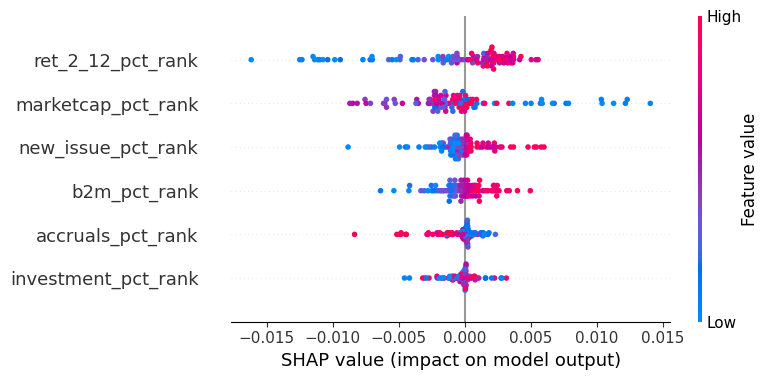

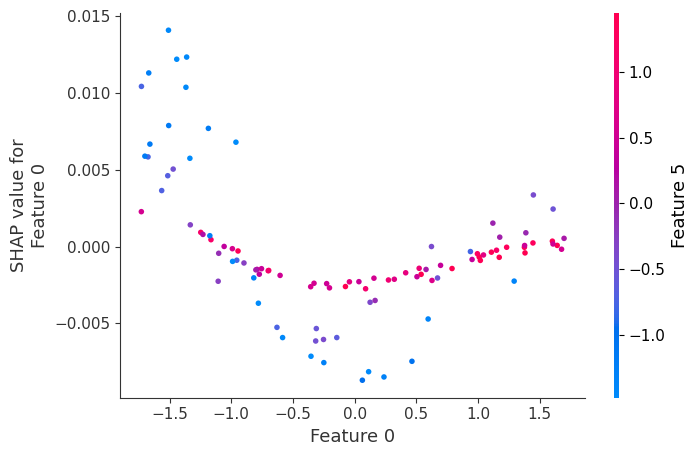

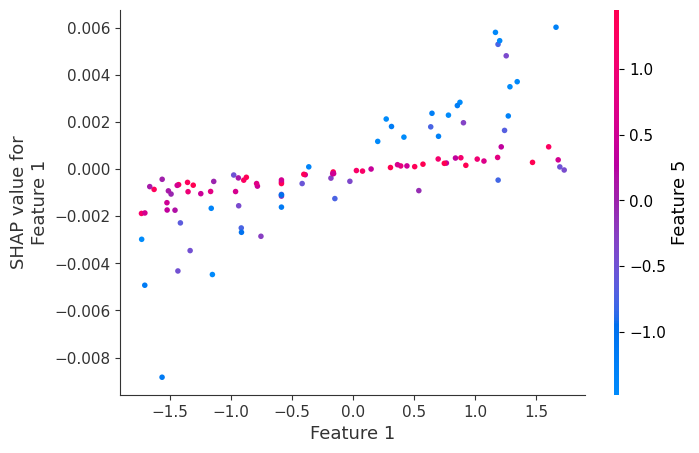

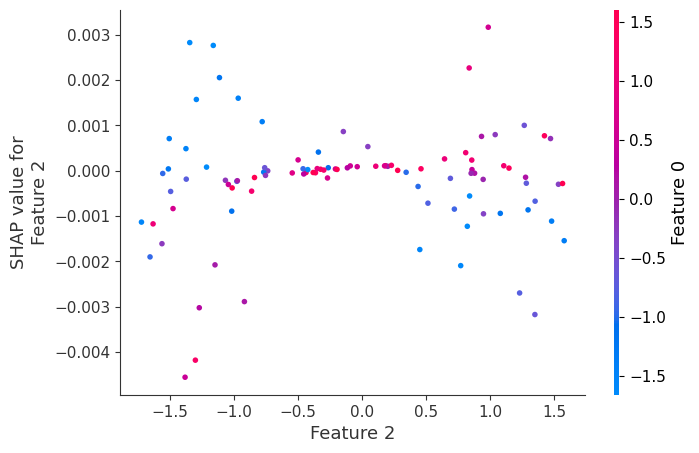

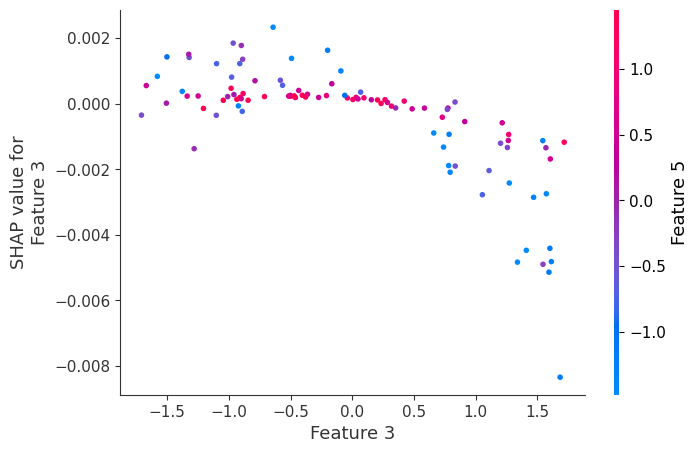

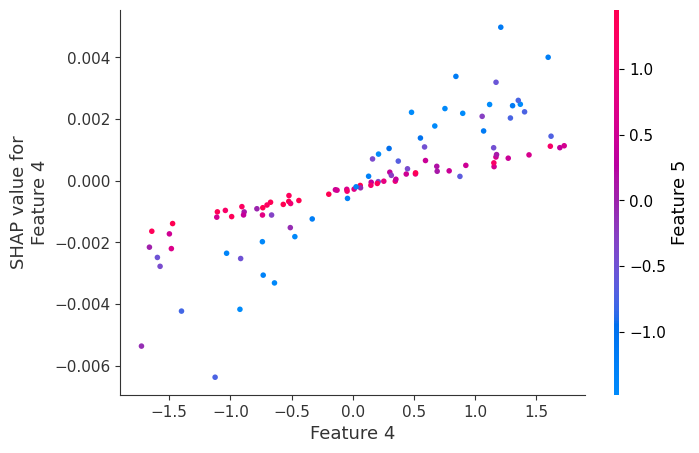

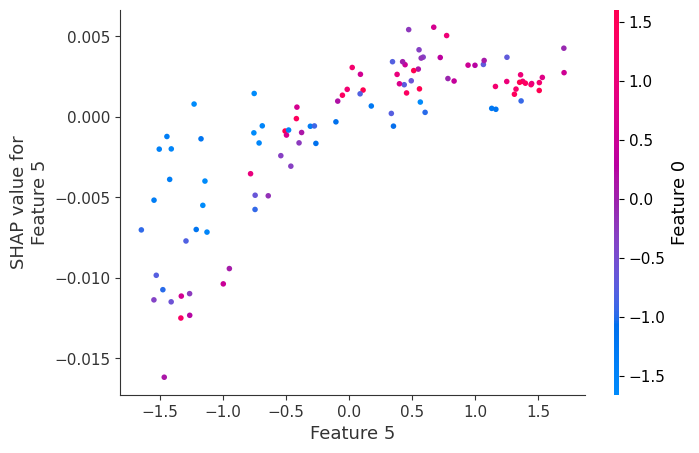

In [19]:
import shap
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle
import numpy as np

# Load the trained model
model_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/deep_neural_trained_model_6_factor_2.h5'
model = load_model(model_path)

# Load the scaler
scaler_path = '/content/drive/MyDrive/Emory/MAF Lecture/Deep_Learning_Code/scaler_6_factor_2.pkl'
with open(scaler_path, 'rb') as file:
    scaler = pickle.load(file)

# Load your validation data (val_X_scaled and val_y)
reg_factors = feature_column_names
y_column_name = 'adj_ret'
val_dat = dat[dat['month_num'] == 161]
val_X = val_dat[reg_factors]
val_y = val_dat[y_column_name]

# Convert the validation data to a NumPy array and scale it
val_X_scaled = scaler.transform(val_X)

# Initialize the SHAP explainer with the model's predict function and the training data
explainer = shap.Explainer(model, val_X_scaled)

# Calculate SHAP values for a subset of data points (e.g., first 100)
num_samples = 100
shap_values = explainer(val_X_scaled[:num_samples])

# Summary plot of SHAP values
shap.summary_plot(shap_values, val_X_scaled[:num_samples], feature_names= feature_column_names)

# Partial dependence plots for selected features (e.g., the first two features)

for i in range(len(feature_column_names)):
  shap.dependence_plot(i, shap_values.values, val_X_scaled[:num_samples])

# Show the plots
plt.show()
